##IDS 575: ML and Statistical Methods

Programming Assignment 4: SVMs

October 24th, 2023

Group Members:
Vaibhav Khurana,
Ayesha Anjum,
Mahsa Merikhipor,


A. Loading the test, train data as dataframes.
A.1: Convert from sparse matrices to dfs

In [2]:
from sklearn.datasets import load_svmlight_file
import pandas as pd

words = pd.read_csv('words.map.txt')

def load_data_svmlight(file_path, total_features):
    # Loading the file with load_svmlight_file
    X, y = load_svmlight_file(file_path, n_features=total_features)  # Explicitly specify the number of features

    # Converting the sparse matrices to dense
    X_dense = X.toarray()

    # At this point, X_dense should have the same number of columns as `total_features`.
    # If not, or to ensure consistency, you could perform a resizing operation. However,
    # since we've used 'n_features' in 'load_svmlight_file', this step might be redundant.

    # Creating DataFrames for the features and the target
    X_df = pd.DataFrame(X_dense)
    y_df = pd.DataFrame(y, columns=['class_label'])

    # Concatenating the features and the target into one DataFrame
    df = pd.concat([X_df, y_df], axis=1)

    return df

total_features = words.shape[0]

# Loading the data
training_df = load_data_svmlight('articles.train', total_features)
test_df = load_data_svmlight('articles.test', total_features)


A.2: Verify the integrity of the data

In [3]:
print('Training Data Shape:', training_df.shape)
print('Test Data Shape:', test_df.shape)
print('Text File Shape:', words.shape)

print('Any null values in training data?', training_df.isnull().values.any())
print('Any null values in test data?', test_df.isnull().values.any())

# Check data types
print(training_df.dtypes)

# Summary statistics for the training data, which will include min/max/count for each column.
# This is a way to quickly verify that each feature column is within expected bounds.
print(training_df.describe())

# Check that class labels are as expected
unique_labels = training_df['class_label'].unique()
print('Unique class labels:', unique_labels)
assert set(unique_labels) <= {1, 2, 3, 4}, "Unexpected class label found!"


Training Data Shape: (4000, 61188)
Test Data Shape: (2400, 61188)
Text File Shape: (61187, 1)
Any null values in training data? False
Any null values in test data? False
0              float64
1              float64
2              float64
3              float64
4              float64
                ...   
61183          float64
61184          float64
61185          float64
61186          float64
class_label    float64
Length: 61188, dtype: object
                 0            1       2            3           4            5  \
count  4000.000000  4000.000000  4000.0  4000.000000  4000.00000  4000.000000   
mean      0.022250     0.155750     0.0     0.028250     0.01475     0.220750   
std       0.313496     1.024819     0.0     0.549115     0.16595     0.656222   
min       0.000000     0.000000     0.0     0.000000     0.00000     0.000000   
25%       0.000000     0.000000     0.0     0.000000     0.00000     0.000000   
50%       0.000000     0.000000     0.0     0.000000     0.000

B. Hard-Margin Classifiers.
B.1: Seperate the features and the labels.

In [4]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score


X_train = training_df.drop('class_label', axis=1)
y_train = training_df['class_label']

X_test = test_df.drop('class_label', axis=1)
y_test = test_df['class_label']


B.2: Re-Label and train the SVM.

In [5]:
from joblib import Parallel, delayed

# Convert features and labels to NumPy arrays for efficiency.
X_train_array = X_train.values
y_train_array = y_train.values
X_test_array = X_test.values
y_test_array = y_test.values


In [6]:

def train_classifier(i, X_train, y_train):
    """
    Function to train a single binary classifier.
    """
    # New model instance; don't reuse instances across different classes
    svm_model = svm.SVC(kernel='linear', C=10000, max_iter=10000)  # Large C for hard margin

    # Create the new binary target
    binary_target = np.where(y_train == i, 1, -1)  # More efficient than apply with a lambda function

    # Train the model
    svm_model.fit(X_train, binary_target)

    return svm_model

# Parallel training of models
classifiers = Parallel(n_jobs=-1)(delayed(train_classifier)(i, X_train_array, y_train_array) for i in range(1, 5))

def classify_point(point):
    """
    Function to classify a single point using all classifiers.
    """
    scores = [clf.decision_function([point]) for clf in classifiers]
    class_label = np.argmax(scores) + 1  # +1 because classes are 1 through 4
    return class_label

# Efficient parallel predictions and evaluations
y_pred_train = np.apply_along_axis(classify_point, 1, X_train_array)  # Replaces inefficient Pandas apply
y_pred_test = np.apply_along_axis(classify_point, 1, X_test_array)

train_error = 1 - accuracy_score(y_train_array, y_pred_train)
test_error = 1 - accuracy_score(y_test_array, y_pred_test)

print(f"Training error: {train_error}")
print(f"Test error: {test_error}")

# Loop for individual errors is fine; not much optimization needed here as it's not the bottleneck
for i, clf in enumerate(classifiers, 1):
    train_preds = clf.predict(X_train_array)
    test_preds = clf.predict(X_test_array)

    # Adjusting labels for the current class being the positive class
    adjusted_y_train = np.where(y_train_array == i, 1, -1)
    adjusted_y_test = np.where(y_test_array == i, 1, -1)

    individual_train_error = 1 - accuracy_score(adjusted_y_train, train_preds)
    individual_test_error = 1 - accuracy_score(adjusted_y_test, test_preds)

    print(f"Classifier {i} - Training error: {individual_train_error}, Test error: {individual_test_error}")


Training error: 0.0
Test error: 0.0970833333333333
Classifier 1 - Training error: 0.0, Test error: 0.04208333333333336
Classifier 2 - Training error: 0.0, Test error: 0.0658333333333333
Classifier 3 - Training error: 0.0, Test error: 0.050833333333333286
Classifier 4 - Training error: 0.0, Test error: 0.0591666666666667


C. Soft-Margin Classifiers, We similarly create soft margin classifiers to determine the best C value

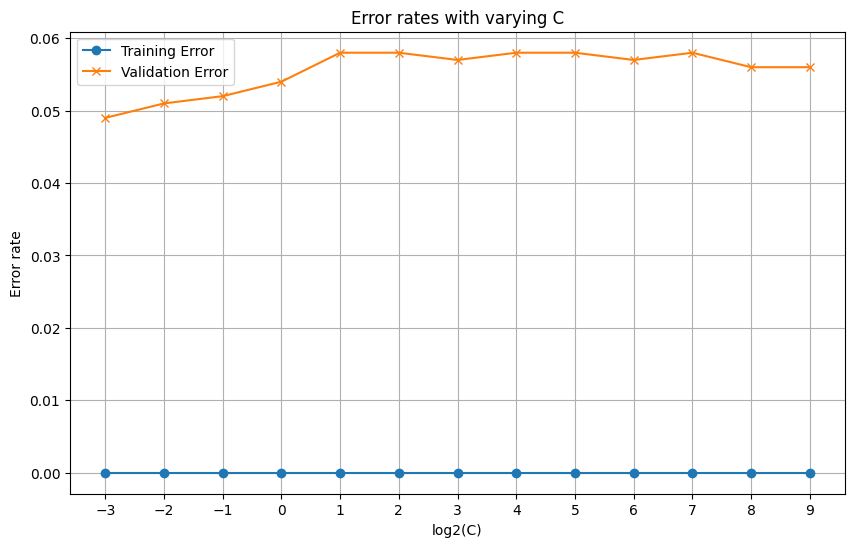

Best C value: 0.125


In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Convert features and labels to NumPy arrays for efficiency
features = training_df.drop('class_label', axis=1).values
labels = training_df['class_label'].values

# Split the data
features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.25, random_state=42)

def train_evaluate_model(C_value):
    training_errors = []
    validation_errors = []

    classifiers = []
    for class_label in range(1, 5):  # Classes 1 through 4
        # Prepare binary labels
        binary_labels_train = (labels_train == class_label).astype(int)
        binary_labels_train[binary_labels_train == 0] = -1  # Set 'non-class' labels to -1

        # Train the model with LinearSVC (more efficient on large datasets)
        model = LinearSVC(dual=False, C=C_value, max_iter=10000)  # dual=False when n_samples > n_features.
        model.fit(features_train, binary_labels_train)
        classifiers.append(model)

    # Make predictions on the training set and calculate error
    predictions_train = np.array([model.decision_function(features_train) for model in classifiers]).argmax(axis=0)
    train_error = 1 - accuracy_score(labels_train, predictions_train + 1)  # +1 to match class labels
    training_errors.append(train_error)

    # Make predictions on the validation set and calculate error
    predictions_val = np.array([model.decision_function(features_val) for model in classifiers]).argmax(axis=0)
    validation_error = 1 - accuracy_score(labels_val, predictions_val + 1)  # +1 to match class labels
    validation_errors.append(validation_error)

    return train_error, validation_error

C_values = [2**i for i in range(-3, 10)]  # List of C values

# Parallel training and evaluation for different C values
results = Parallel(n_jobs=-1)(delayed(train_evaluate_model)(C) for C in C_values)

# Extracting training and validation errors
training_errors, validation_errors = zip(*results)

# Identifying the best C
best_C_index = np.argmin(validation_errors)
best_C_value = C_values[best_C_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.log2(C_values), training_errors, marker='o', label='Training Error')
plt.plot(np.log2(C_values), validation_errors, marker='x', label='Validation Error')
plt.title('Error rates with varying C')
plt.xlabel('log2(C)')
plt.ylabel('Error rate')
plt.legend()
plt.grid(True)
plt.xticks(np.log2(C_values))

plt.show()

print(f"Best C value: {best_C_value}")


D. Soft-Margin Classifiers using entire training dataset and the best C-value.

In [9]:

# 'best_C_value' and data arrays already defined
best_C_value = 0.125

# Initialize an array to store your classifiers
classifiers = []

# Train a binary classifier for each class
for i in range(1, 5):  # Assuming classes are labeled 1 through 4
    print(f"Training classifier for class {i}...")

    # Adjust the labels for binary classification
    binary_target = np.where(y_train_array == i, 1, -1)

    # Create a new SVM classifier
    svm_model = svm.SVC(kernel='linear', C=best_C_value)

    # Train the classifier on the entire training data
    svm_model.fit(X_train_array, binary_target)

    # Save the trained classifier
    classifiers.append(svm_model)

    # Predict on the training set itself
    y_train_pred = svm_model.predict(X_train_array)

    # Calculate the error rate on the training data
    error = 1 - accuracy_score(binary_target, y_train_pred)

    # Print error for each classifier
    print(f"Classifier {i} Training Error: {error}")




Training classifier for class 1...
Classifier 1 Training Error: 0.00024999999999997247
Training classifier for class 2...
Classifier 2 Training Error: 0.0010000000000000009
Training classifier for class 3...
Classifier 3 Training Error: 0.0007500000000000284
Training classifier for class 4...
Classifier 4 Training Error: 0.00024999999999997247


E. Normalize the feature vectors and repeat part c

In [ ]:
from sklearn import svm, preprocessing


# Assuming 'X_train_array' and 'y_train_array' are your features and labels
# Normalize the feature vectors
X_normalized = preprocessing.normalize(X_train_array, norm='l2')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y_train_array, test_size=0.25, random_state=42
)

# Initialize a list to store the classifiers
classifiers = []

# The C value for the soft margin classifiers
C_value = 0.125

# Training classifiers for each class
for i in range(1, 5):  # Classes are 1 through 4
    # Convert labels to binary (1 for the current class, -1 for all other classes)
    binary_y_train = np.where(y_train == i, 1, -1)
    binary_y_val = np.where(y_val == i, 1, -1)

    # Initialize SVM with the specific C value
    svm_model = svm.SVC(kernel='linear', C=C_value)

    # Train the classifier
    svm_model.fit(X_train, binary_y_train)

    # Store the classifier
    classifiers.append(svm_model)

    # Predict on the validation set
    y_val_pred = svm_model.predict(X_val)

    # Calculate the error rate
    error = 1 - accuracy_score(binary_y_val, y_val_pred)

    # Print error for each classifier
    print(f"Classifier {i} Validation Error: {error}")

# You now have a list 'classifiers' with four trained models,
# and individual validation errors printed for each.


Classifier 1 Validation Error: 0.09399999999999997
Classifier 2 Validation Error: 0.236
Classifier 3 Validation Error: 0.09799999999999998
Classifier 4 Validation Error: 0.11099999999999999


F. One vs One Classifier

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

# 'best_C_value' contains the best value for C found from the previous part, which is 0.125 here
best_C_value = 0.125

# Create the SVM model
svm_model = SVC(kernel='linear', C=best_C_value)

# Create the one-vs-one multi-class classifier
ovo_classifier = OneVsOneClassifier(svm_model)

# Train the classifier on the full training set
ovo_classifier.fit(X_train_array, y_train_array)

# Predict the test set results
y_pred = ovo_classifier.predict(X_test_array)

# Calculate the accuracy
accuracy = accuracy_score(y_test_array, y_pred)

print(f"1-vs-1 classification accuracy: {accuracy:.2f}")

# If you're interested in detailed performance metrics, you can use classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_array, y_pred))


1-vs-1 classification accuracy: 0.90
              precision    recall  f1-score   support

         1.0       0.93      0.87      0.90       600
         2.0       0.88      0.90      0.89       600
         3.0       0.92      0.91      0.92       600
         4.0       0.86      0.91      0.88       600

    accuracy                           0.90      2400
   macro avg       0.90      0.90      0.90      2400
weighted avg       0.90      0.90      0.90      2400



In [11]:
from sklearn import svm, preprocessing


# Assuming 'X_train_array' and 'y_train_array' are your features and labels
# Normalize the feature vectors
X_train_norm = preprocessing.normalize(X_train, norm='l2')
X_test_norm = preprocessing.normalize(X_test, norm='l2')

from sklearn.svm import SVC

# Define the range of C values you want to try.
C_values = [2**i for i in range(-3, 10)]

# This function will help in training the SVM with a given C value.
def train_and_evaluate_svm(X, y, label, C):
    """
    Trains an SVM and evaluates its performance.
    """
    y_binary = np.where(y == label, 1, -1)  # Create binary labels
    model = SVC(kernel='linear', C=C)
    model.fit(X, y_binary)

    # If validation data is available, predict and calculate error
    y_pred = model.predict(X)  # you can replace X with your validation set, if available
    error = 1 - accuracy_score(y_binary, y_pred)

    return error

# Testing different C values and finding the best one
errors_for_c = []

for C in C_values:
    errors_for_label = []
    for label in [1, 2, 3, 4]:
        error = train_and_evaluate_svm(X_train_norm, y_train_array, label, C)
        errors_for_label.append(error)
    errors_for_c.append(np.mean(errors_for_label))

# Finding the optimal C based on the error
best_C_index = np.argmin(errors_for_c)
best_C_value = C_values[best_C_index]

print(f"Best C-value is: {best_C_value}")

# Initialize a list to store the classifiers
classifiers = []

# Best C_value determined before this step based on your analysis
C_value = best_C_value  # replace with your best C value

# Loop through each class label to train a separate classifier
for i in range(1, 5):  # Assuming class labels are from 1 to 4
    print(f"Training classifier for class {i}...")

    # Convert the labels: 1 for the current class and -1 for all other classes
    binary_y_train = np.where(y_train == i, 1, -1)

    # Initialize the SVM classifier with the optimal C value
    svm_model = svm.SVC(kernel='linear', C=C_value)

    # Train the classifier with the binary labels
    svm_model.fit(X_train_norm, binary_y_train)

    # Save the trained classifier to the list
    classifiers.append(svm_model)

    # Predict on the test set and calculate the error
    y_test_pred = svm_model.predict(X_test_norm)  # Predictions on test data

    # Prepare binary labels for the test set too
    binary_y_test = np.where(y_test == i, 1, -1)

    # Calculate the error rate for the predictions
    error = 1 - accuracy_score(binary_y_test, y_test_pred)

    # Output the error rate for each classifier
    print(f"Classifier for class {i} Error: {error}")


# You now have a list 'classifiers' with four trained models,
# and individual validation errors printed for each.